# IMDB Movie Review Sentiment Analysis
By Zeyad Ahmed and Hasehm Bader

## Problem and Motivation

Sentiment analysis of movie reviews helps movie studios, streaming platforms, and researchers understand audience sentiment at scale. This enables data-driven decision-making for marketing, content recommendations, and product improvements. Automated text analysis is crucial for processing thousands of reviews, which would be infeasible to analyze manually.

## Dataset Description

- **Name:** IMDB Dataset of 50K Movie Reviews
- **Source:** [Kaggle: lakshmi25npathi/imdb-dataset-of-50k-movie-reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)
- **Rows:** 50,000
- **Columns:**
    - `review`: The text of the review
    - `sentiment`: Label (positive/negative)
- **Data Types:**
    - `review`: string (text)
    - `sentiment`: categorical
- **Missingness:** No missing values in either column
- **Sensitive Attributes:** Reviews may contain personal opinions and references to individuals

### Loading the Dataset

We downloaded the data and stored it at `../data/imdb_dataset.csv`

In [25]:
path = '../data/imdb_dataset.csv'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    learning_curve,
    GridSearchCV
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    mean_absolute_error,
    mean_squared_error
)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


# plotting style and random state
sns.set_style('whitegrid')
RANDOM_STATE = 42

### Explore the dataset

In [27]:
df = pd.read_csv(path)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [28]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [29]:
# Seeing the whole dataset and number of rows and columns
print(df.shape)
df

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [30]:
# 📋 Summary of the DataFrame — shows column names, data types, non-null values, and memory usage
df.info()
# 🧮 Calculate the total number of missing (NaN) values for each column in the DataFrame
missing_counts = df.isnull().sum()

# 🖨️ Print a summary showing how many missing values exist in each column
print("Missing values in each column:")
missing_counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
Missing values in each column:


review       0
sentiment    0
dtype: int64

In [31]:
# examine the class distribution
df.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

## EDA

### searching for duplicates

In [32]:
duplicated = df.duplicated()
print(f"Number of duplicated rows: {duplicated.sum()}")

Number of duplicated rows: 418


### removing the duplicates

In [33]:
# Remove duplicates
df = df.drop_duplicates()

# Check again for duplicates
duplicated = df.duplicated()

print(f"Number of duplicated rows: {duplicated.sum()}")
print(f"New shape of the DataFrame: {df.shape}")

Number of duplicated rows: 0
New shape of the DataFrame: (49582, 2)


In [34]:
df['sentiment'].value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

### Plot 1 – Target distribution plot for classification (bar plot of class counts).

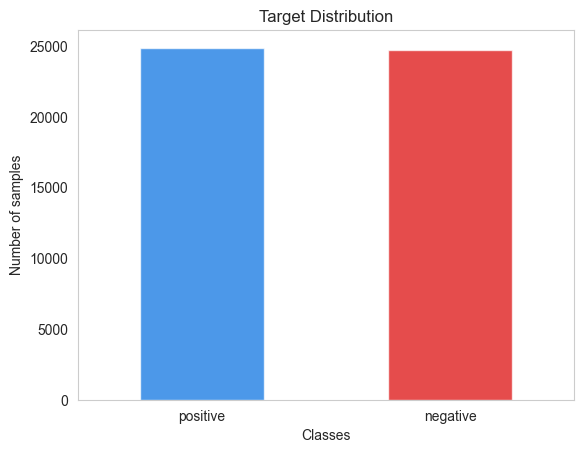

In [35]:
# Visualizing the target distribution

target_plot = df['sentiment'].value_counts().plot(kind='bar', 
                                    title='Target Distribution', 
                                    xlabel='Classes', 
                                    ylabel='Number of samples', 
                                    color=['#006ce0', '#db0000'],
                                    alpha=0.7,
                                    grid=False)
target_plot.set_xticklabels(target_plot.get_xticklabels(), rotation=0)
plt.show()
# save the figure
target_plot.figure.savefig('../plots/target_distribution.png')
# save fig with path windows format and mac format using os library


In [36]:
# clean the text data without removing stop words
import re
import string
def clean_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [37]:
# clean the df review column and save new dataframe
df['cleaned_review'] = df['review'].apply(clean_text)
df[['review', 'cleaned_review']].head()


C:\Users\User\AppData\Local\Temp\ipykernel_12624\899532256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_review'] = df['review'].apply(clean_text)


,review,cleaned_review
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love in the time of money is a ...


In [38]:
# drop the old review column
df = df.drop(columns=['review'])
# rename cleaned_review to review for simplicity
df = df.rename(columns={'cleaned_review': 'review'})
# save csv
df.to_csv('../data/imdb_dataset_cleaned.csv', index=False)
# update path and reload dataframe
path = '../data/imdb_dataset_cleaned.csv'
df = pd.read_csv(path)

In [39]:
df.head()

,sentiment,review
0,positive,one of the other reviewers has mentioned that ...
1,positive,a wonderful little production the filming tech...
2,positive,i thought this was a wonderful way to spend ti...
3,negative,basically theres a family where a little boy j...
4,positive,petter matteis love in the time of money is a ...


###  Plot 2 – Correlation heatmap or boxplot summary for key numeric features.


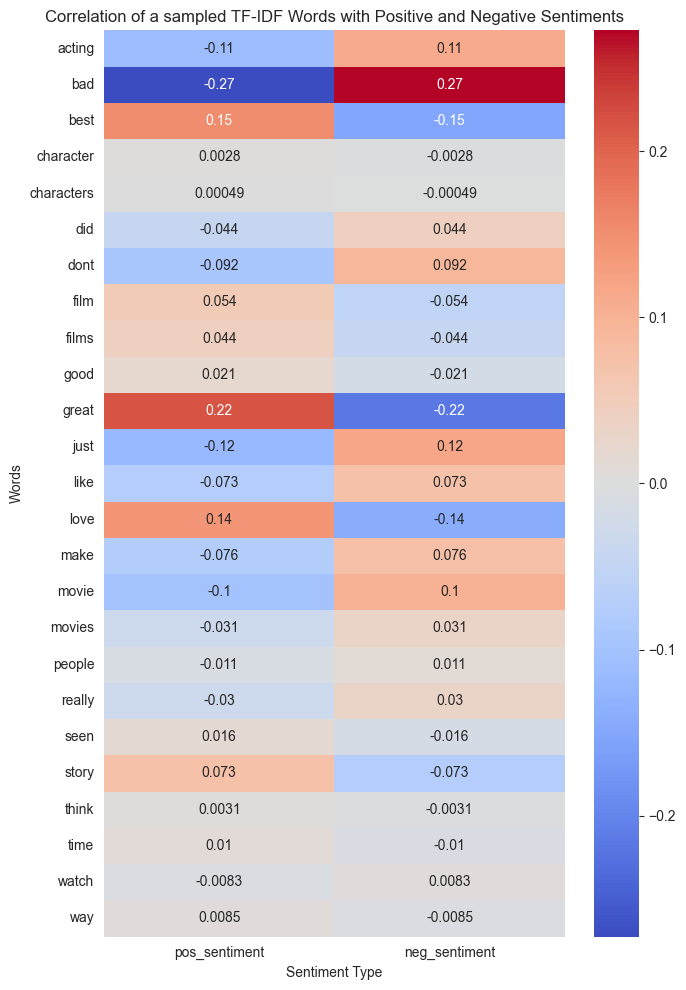

In [40]:
df = df.copy()

# Create binary sentiment columns
df['pos_sentiment'] = (df.sentiment == 'positive').astype(int)
df['neg_sentiment'] = (df.sentiment == 'negative').astype(int)

# TF-IDF feature extraction (limit features for visibility)
vectorizer = TfidfVectorizer(max_features=25, stop_words='english', ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(df.review)

# Build DataFrame from TF-IDF matrix
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Add sentiment columns
tfidf_df['pos_sentiment'] = df['pos_sentiment']
tfidf_df['neg_sentiment'] = df['neg_sentiment']

# Compute correlations
corr = tfidf_df.corr()[['pos_sentiment', 'neg_sentiment']].drop(['pos_sentiment', 'neg_sentiment'])

# Plot heatmap
p = plt.figure(figsize=(7, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of a sampled TF-IDF Words with Positive and Negative Sentiments')
plt.xlabel('Sentiment Type')
plt.ylabel('Words')
plt.tight_layout()
plt.show()

# Save figure with high quality
p.savefig('../plots/tfidf_correlation_heatmap.png', dpi=300)

## Classification ML

### Train-Validation-Test Split + LR Model

In [41]:
# Train-test split (70% train, 30% test)
x = df['review']
y = df['sentiment']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

# Create a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

# cross-validation on training set (with 5 folds)
cv_scores = cross_val_score(pipeline, x_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores and mean scores
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores):.4f}")

# Train model
pipeline.fit(x_train, y_train)

# Step 5: Evaluate on test set
test_accuracy = pipeline.score(x_test, y_test)
print(f"Test set accuracy: {test_accuracy:.4f}")

# Print report 
y_pred = pipeline.predict(x_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Cross-validation scores: [0.88764045 0.89037741 0.89223455 0.8838784  0.89093791]
Mean CV accuracy: 0.8890
Test set accuracy: 0.8911
Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.87      0.89      7410
    positive       0.88      0.91      0.89      7465

    accuracy                           0.89     14875
   macro avg       0.89      0.89      0.89     14875
weighted avg       0.89      0.89      0.89     14875



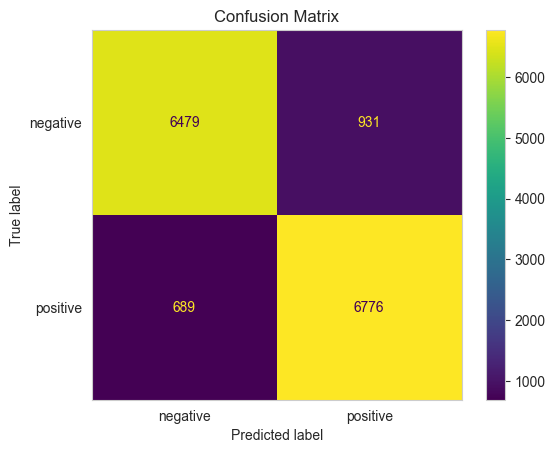

In [51]:
# plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay.from_estimator(
    pipeline,
    x_test,
    y_test,
    display_labels=pipeline.classes_,
    normalize=None,
    cmap=plt.cm.viridis
    )
cm_display.ax_.set_title('Confusion Matrix')
# remove grid lines
cm_display.ax_.grid(False)
plt.show()
# save confusion matrix figure
cm_display.figure_.savefig('../plots/confusion_matrix.png', dpi=300)

### Learning Curve

In [ ]:
# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    pipeline, x_train, y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 8),
    scoring='accuracy',
    shuffle=True,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Calculate mean training and validation scores
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Logistic Regression Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Improve the model: finding the best parameters

In [ ]:
# Define parameter grid
param_grid = {
    'tfidf__max_features': [3000, 5000, 10000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.1, 1, 10],
}

# Run grid search with cross-validation
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit on training data
grid.fit(x_train, y_train)

# Show best parameters and score
print("Best Parameters:", grid.best_params_)
print(f"Best Cross-Validation Accuracy: {grid.best_score_:.4f}")

# Evaluate best model on test set
best_model = grid.best_estimator_
test_accuracy = best_model.score(x_test, y_test)
print(f"Test Set Accuracy with Best Model: {test_accuracy:.4f}")


### Learning curve

In [ ]:
# Generate learning curve
train_sizes, train_scores, val_scores = learning_curve(
    best_model, x_train, y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 8),
    scoring='accuracy',
    shuffle=True,
    random_state=42,
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Logistic Regression Model(CV={cv_value})'.format(cv_value=5))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Cross-validation score with CV=5
val_scores_cv = cross_val_score(best_model, x_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(f"✅ Cross-Validation Accuracy (CV=5): Mean = {np.mean(val_scores_cv):.4f}, Std = {np.std(val_scores_cv):.4f}")

# Train best model on full training set
best_model.fit(x_train, y_train)

# Evaluate on test set
test_accuracy = best_model.score(x_test, y_test)
print(f"✅ Final Test Set Accuracy: {test_accuracy:.4f}")


### NB model

In [18]:
# Create a pipeline
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# cross-validation on training set (with 5 folds)
nb_cv_scores = cross_val_score(nb_pipeline, x_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores and mean scores
print(f"Cross-validation scores: {nb_cv_scores}")
print(f"Mean CV accuracy: {np.mean(nb_cv_scores):.4f}")

# Train the model on training set
nb_pipeline.fit(x_train, y_train)


# Evaluate on test set
nb_test_accuracy = nb_pipeline.score(x_test, y_test)
print(f"Test set accuracy: {nb_test_accuracy:.4f}")

Cross-validation scores: [0.85955056 0.857966   0.8626999  0.86356433 0.85736926]
Mean CV accuracy: 0.8602
Test set accuracy: 0.8633


### learning curve for NB

In [ ]:
# Generate learning curve data for Naive Bayes model
train_sizes, train_scores, val_scores = learning_curve(
    nb_pipeline, x_train, y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 8),
    scoring='accuracy',
    shuffle=True,
    random_state=42,
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Naive Bayes Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### NB Improvement

In [ ]:
# Define parameter grid
nb_param_grid = {
    'tfidf__max_features': [3000, 5000, 10000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__alpha': [0.1, 0.5, 1.0],
}

# Run grid search with cross-validation
nb_grid = GridSearchCV(
    nb_pipeline,
    nb_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit on training data
nb_grid.fit(x_train, y_train)

# Show best parameters and score
print("Best Parameters:", nb_grid.best_params_)
print(f"Best Cross-Validation Accuracy: {nb_grid.best_score_:.4f}")

# Evaluate best model on test set
nb_best_model = nb_grid.best_estimator_
nb_test_accuracy = nb_best_model.score(x_test, y_test)
print(f"Test Set Accuracy with Best Model: {nb_test_accuracy:.4f}")


### The best NB model with cv = 5

In [ ]:
# Generate learning curve for the best CV value
train_sizes, train_scores, val_scores = learning_curve(
    nb_best_model, x_train, y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 8),
    scoring='accuracy',
    shuffle=True,
    random_state=42,
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Naive Bayes Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Cross-validation score with CV=5
nb_val_scores_cv = cross_val_score(nb_best_model, x_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(f"✅ Cross-Validation Accuracy (CV=5): Mean = {np.mean(nb_val_scores_cv):.4f}, Std = {np.std(nb_val_scores_cv):.4f}")

# Train best model on full training data
nb_best_model.fit(x_train, y_train)

# Evaluate on test set
nb_test_accuracy = nb_best_model.score(x_test, y_test)
print(f"✅ Final Test Set Accuracy: {nb_test_accuracy:.4f}")


### regression part

✅ Continuous sentiment strength range: -1.000 → 1.000
Linear Regression → MAE: 0.3699 | RMSE: 0.5716
Decision Tree Regressor → MAE: 0.0000 | RMSE: 0.0000


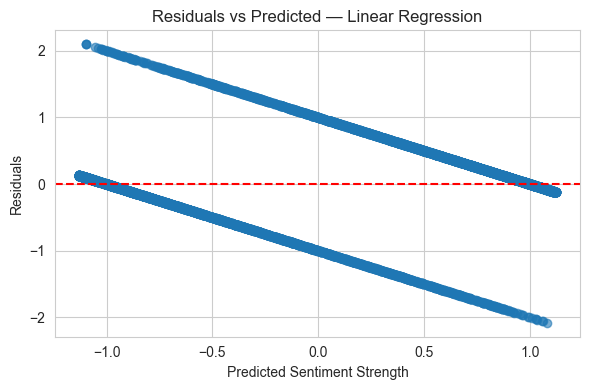

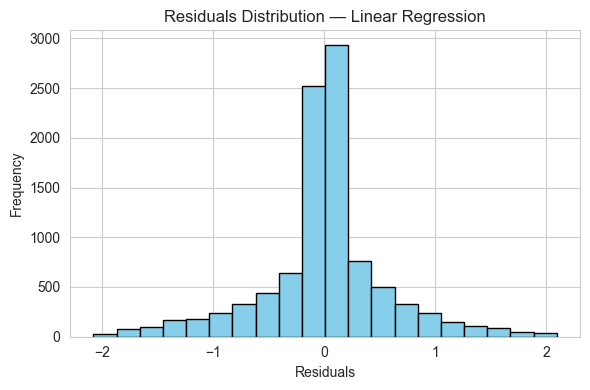

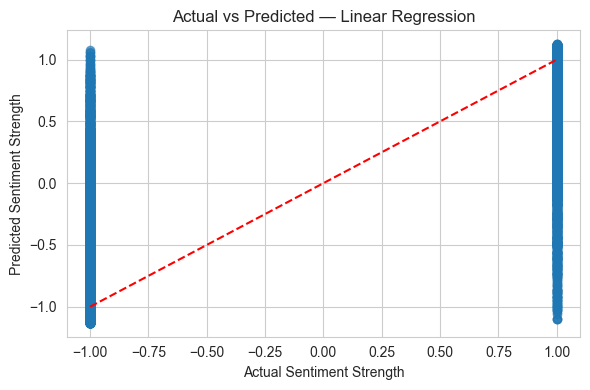

In [ ]:
# 📘 Regression Task: Continuous Sentiment Strength using Logistic Regression Weights

df["sentiment_strength_label"] = df["sentiment"].map({"positive": 1, "negative": -1})

X_train, X_test, y_train, y_test = train_test_split(
    df["review"], df["sentiment"], test_size=0.2, random_state=42, stratify=df["sentiment"]
)


# Fit TF-IDF separately so we can access transformed matrices
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Fit Logistic Regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

# Compute raw scores using weight matrix w·x + b
w = clf.coef_[0]          # weight vector
b = clf.intercept_[0]     # bias term
z = X_test_tfidf.dot(w) + b  # linear combination

# Apply sigmoid and scale to [-1, 1]
sigmoid = lambda x: 1 / (1 + np.exp(-x))
sentiment_strength = 2 * sigmoid(z) - 1

print(f"✅ Continuous sentiment strength range: {sentiment_strength.min():.3f} → {sentiment_strength.max():.3f}")

# True continuous labels
y_true = y_test.map({"positive": 1, "negative": -1}).values

# ---------------------------------------------------------------
# 3️⃣ Train Regression Baselines
# ---------------------------------------------------------------

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(sentiment_strength.reshape(-1, 1), y_true)
lin_pred = lin_reg.predict(sentiment_strength.reshape(-1, 1))

# Decision Tree Regressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(sentiment_strength.reshape(-1, 1), y_true)
tree_pred = tree_reg.predict(sentiment_strength.reshape(-1, 1))

# ---------------------------------------------------------------
# 4️⃣ Evaluation Metrics
# ---------------------------------------------------------------

def evaluate_regression(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} → MAE: {mae:.4f} | RMSE: {rmse:.4f}")

evaluate_regression(y_true, lin_pred, "Linear Regression")
evaluate_regression(y_true, tree_pred, "Decision Tree Regressor")




# ---- Plot 3: Residuals Histogram (Linear Regression) ----
plt.figure(figsize=(6, 4))
plt.hist(lin_residuals, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution — Linear Regression')
plt.tight_layout()
plt.show()


